### Some tips
* `tensor.squeeze()`: delete dimensions with size 1, egg. `[1, 28, 28] -> [28, 28]`
* `tensor.flatten(start_dim=0)`: expend tensor to one dimension, egg. `[1, 28, 28] -> [784]`
* `transforms.ToTensor()`:  convert `(H x W x C)` of `[0, 255]` to a torch.FloatTensor `(C x H x W)` of `[0.0, 1.0]`
* `tensor.argmax(dim=1)`: return indices of the maximum values across a dimension
* `torch.sum(t_x == t_x)`: compute the number of elements in x equals to that in y
* `torch.cat(tensors, dim=0)`: concatenates tensor tuples
* `torch.stack(tensors, dim=0)`: concatenates tensor tuples along a new dimension
* `torch.unsqueeze(input, dim)`: insert a dimension of size one at the specified position to a tensor

In [1]:
import torch
from torchvision import datasets, transforms
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import torch.nn.functional as F
import time
import math
import matplotlib.pyplot as plt
import torchvision.utils as vutils
import numpy as np
import torchvision.models as tvmodels
from torch.autograd import Variable
manualseed = 47
device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")
print(device)

cuda:0


### Step 1: Create fake datasets 

#### Create dataset with fake images

In [2]:
from torch.utils.data import Dataset, DataLoader

class Generator(nn.Module):
    def __init__(self, ngf = 32):
        super(Generator,self).__init__()
        self.gen=nn.Sequential(
            # 输入是 Z, 对Z进行卷积
            nn.ConvTranspose2d(200, ngf*8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf*8),
            nn.ReLU(inplace=True),
            # 输入特征图大小. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf*8, ngf*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf*4),
            nn.ReLU(inplace=True),
            # 输入特征图大小. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(ngf*4, ngf*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(inplace=True),
            # 输入特征图大小. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf*2, 3, 4, 2, 1, bias=False),
            nn.Tanh()
            # 输入特征图大小. (nc) x 32 x 32
        )
    def forward(self, x):
        x=self.gen(x)
        return x





class FakeNumberDataset(Dataset):
    def __init__(self, dataset_name="mnist",transform=None):
        """
            mix_ratio: real/fake
        """

        if dataset_name=="mnist":
            odataset = datasets.MNIST('MNIST_data', train=True, transform=transform)
        elif dataset_name=="fashion_mnist":
            odataset = datasets.FashionMNIST('MNIST_data', train=True, transform=transform)
        elif dataset_name=="cifar10":
            odataset = datasets.CIFAR10('MNIST_data', train=True, transform=transform)
        elif dataset_name=="cifar100":
            odataset = datasets.CIFAR100('MNIST_data', train=True, transform=transform)
        else:
            print("Wrong argument for dataset_name!")
            return None
    


        self.label = []
        self.items = []
        ############################
        n_z=100
        ############################
        #target_num = mix_ratio * fake_images.shape[0]
        #self.added_real = 0 
#         print(len(odataset))
   
        netG = Generator().to(device)
        netG.load_state_dict(torch.load('C:\\Users\\lz172\\Desktop\\CIFAR100\\netG_params.pkl'))
        for idx in range(len(odataset)):
            x_idx, y_idx = odataset[idx]
#             print(x_idx)
#             if y_idx:
#                 self.items.append(x_idx)
#                 self.label.append(y_idx)

            noise1 = torch.randn(1, 100)
            labels_onehot1 = np.zeros((1,100))
            labels_onehot1[np.arange(1),y_idx]=1 # 这个9换成想生成的数字
            noise1=np.concatenate((noise1.cpu().numpy(), labels_onehot1),axis=1)
            # 每张图片是0到9之间的数字
            labels_onehot1 = Variable(torch.from_numpy(labels_onehot1).float())
#                 labels_onehot = Variable(torch.from_numpy(labels_onehot).float())
            noise1=noise1.reshape([-1, 200, 1, 1])
            noise1=Variable(torch.from_numpy(noise1).float())                
            fake_image1 = netG(noise1.to(device)).detach().cpu()
            fake_image_first = torch.squeeze(fake_image1,0)
            #######第二个假图片######
            noise2 = torch.randn(1, 100)
            labels_onehot2 = np.zeros((1,100))
            labels_onehot2[np.arange(1),y_idx]=1 # 这个9换成想生成的数字
            noise2=np.concatenate((noise2.cpu().numpy(), labels_onehot2),axis=1)
            # 每张图片是0到9之间的数字
            labels_onehot2 = Variable(torch.from_numpy(labels_onehot2).float())
#                 labels_onehot = Variable(torch.from_numpy(labels_onehot).float())
            noise2=noise2.reshape([-1, 200, 1, 1])
            noise2=Variable(torch.from_numpy(noise2).float())                
            fake_image2 = netG(noise2.to(device)).detach().cpu()
            fake_image_second = torch.squeeze(fake_image2,0)
            ########################
            a1 = torch.rand(1)
            a2 = torch.rand(1)
            lamma1 = min(a1,a2)
            lamma2 = abs(a1-a2)
            lamma3 = 1-max(a1,a2)
#                 x_idx = (a1*0.25+0.35)*x_idx + (0.65-a1*0.25)*fake_image_first
            x_idx = (a1*0+0.85)*x_idx + (0.15-a1*0)*fake_image_first 

#                 x_idx = lamma1*x_idx + lamma2*fake_image_first+lamma3*fake_image_second
#                 print(x_idx.shape)
#                 x_idx = fake_image
            self.items.append(x_idx)
            self.label.append(y_idx)

            ##############################################
            
             

    def checkAddedRealImgs(self):
        return self.added_real
    
    def __len__(self):
        return len(self.items)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        return self.items[idx], self.label[idx]

# transform = transforms.Compose([transforms.Resize(32),transforms.ToTensor(), transforms.Normalize((0.5,),(0.5,))])
# trainset = datasets.MNIST('MNIST_data', download=True, train=True, transform=transform)

# train_dataset_with_fake = FakeNumberDataset(fake_images=fake_images[0:6000], mix_ratio=0.01, odataset=trainset)
# trainloader = torch.utils.data.DataLoader(train_dataset_with_fake, batch_size=64, shuffle=True)


# testset = datasets.MNIST('MNIST_data', train=False, transform=transform)
# testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

# print("Number of Train:", len(train_dataset_with_fake), "Number of Test:", len(testset))

### Step 2: create a neural network model (global classifier)

In [3]:
class Model(nn.Module):
    def __init__(self, n_channel=1):
        super(Model, self).__init__()
        self.conv1 = nn.Sequential(nn.Conv2d(n_channel, 16, 3), nn.ReLU())
        self.pool1 = nn.MaxPool2d(2, stride=1)
        self.conv2 = nn.Sequential(nn.Conv2d(16, 64, 3), nn.ReLU())
        self.pool2 = nn.MaxPool2d(2, stride=1)
        self.dropout = nn.Dropout(p=0.5)
        self.lfc1 = nn.Linear(64*26*26, 100)      # 这个4注意改掉
        self.lfc2 = nn.Linear(100, 100)
                                      
    def forward(self, x):
        x = self.conv1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.pool2(x)
        x = self.dropout(x)
        x = torch.flatten(x, start_dim=1)
        return self.lfc2(self.lfc1(x))

test_m = Model()
print(test_m)
"""
for param in test_m.parameters():
    print(type(param.data), param.size())

x, y = next(iter(testloader))
print(x.shape)
x = nn.Conv2d(3, 16, 3)(x)
print(x.shape)
x = nn.MaxPool2d(2, stride=1)(x)
print(x.shape)
x = nn.Conv2d(16, 64, 3)(x)
print(x.shape)
x = nn.MaxPool2d(2, stride=1)(x)
print(x.shape)
"""

Model(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
  )
  (pool1): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  (conv2): Sequential(
    (0): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
  )
  (pool2): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.5, inplace=False)
  (lfc1): Linear(in_features=43264, out_features=100, bias=True)
  (lfc2): Linear(in_features=100, out_features=100, bias=True)
)


'\nfor param in test_m.parameters():\n    print(type(param.data), param.size())\n\nx, y = next(iter(testloader))\nprint(x.shape)\nx = nn.Conv2d(3, 16, 3)(x)\nprint(x.shape)\nx = nn.MaxPool2d(2, stride=1)(x)\nprint(x.shape)\nx = nn.Conv2d(16, 64, 3)(x)\nprint(x.shape)\nx = nn.MaxPool2d(2, stride=1)(x)\nprint(x.shape)\n'

### Step 3: train data (Adam)

3
number of imgs in train set: 50000
Start training loop...
-------------------------------------
300 782
600 782
[1\3], loss: 2.8190855979919434, train accuracy: 0.24883998930454254, test accuracy: 0.30660000443458557.
0m 7s (- 0m 14s) (1 33%)
-------------------------------------
300 782
600 782
[2\3], loss: 2.3321731090545654, train accuracy: 0.4060399830341339, test accuracy: 0.3333999812602997.
0m 14s (- 0m 7s) (2 66%)
-------------------------------------
300 782
600 782
[3\3], loss: 2.4917776584625244, train accuracy: 0.49257999658584595, test accuracy: 0.3367999792098999.
0m 21s (- 0m 0s) (3 100%)


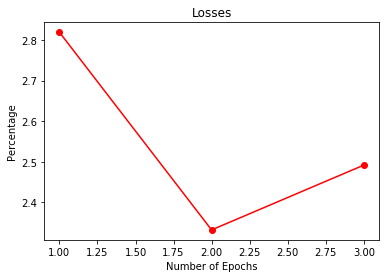

In [4]:
import time
import math
def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    h = math.floor(m / 60)
    m -= h * 60
    return '%dm %ds' % (m, s) if h==0 else '%dh %dm %ds' % (h, m, s)

def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

def checktestaccur( m, testdataloader, datasetsize):
    # test 用的是真实数据，包括6
    m.eval()
    positive = float(0)
    all_8=true_8=float(0)
    with torch.no_grad():
        
        
        for x, y in testdataloader:
            x = x.to(device)
#             print(x.shape)
            y = y.to(device)
#             print(y.shape)
            yhat = m(x)
            positive += torch.sum(yhat.argmax(dim=1) == y)
#             pre = yhat.argmax(dim=1)
#             for i in range(len(y)):
#                 if y[i].data == 8:
#                     all_8 += 1
#                     if pre[i].data == 8:
#                         true_8 += 1

    return positive/datasetsize
#     return true_8/all_8
        
epoches = 3  # 2 is best, 3 is fine
# change n_channel
print(epoches)
model = Model(n_channel=3).to(device)  
optimizer = torch.optim.Adam(model.parameters()) 
loss_fn = torch.nn.CrossEntropyLoss()
###################################################
transform = transforms.Compose([transforms.Resize(32),transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
# Mnist or FashionMnist
train_dataset_with_fake = FakeNumberDataset(dataset_name="cifar100",transform=transform)
trainloader = torch.utils.data.DataLoader(train_dataset_with_fake, batch_size=64, shuffle=True)
# MNIST or FashionMNIST
testset = datasets.CIFAR100('MNIST_data', train=False, transform=transform) 
# testset = datasets.CIFAR10('MNIST_data',  train=False, transform=transform)

testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True) 
###################################################

losses = [] 
trainaccurs = []
testaccurs = []
epoch_sample = len(train_dataset_with_fake)    #    注意这个base数字
print("number of imgs in train set:", epoch_sample)
start = time.time()
print("Start training loop...")
for epoch in range(1, epoches+1):
    print("-------------------------------------")
    accurate = float(0)
    idx = 0
    for x, y in trainloader:
        x = x.to(device)
        y = y.to(device)
        model.train()
        optimizer.zero_grad()
#         print(x.shape)
        yhat = model(x)
        loss = loss_fn(yhat, y)
        loss.backward(retain_graph=True)
        optimizer.step()
        
        yhat = yhat.argmax(dim=1)
        accurate += (y==yhat).float().sum()
        idx += 1
        if idx % 300 == 0:
            print(idx, len(trainloader))
        
    losses.append(loss)

    testaccur = checktestaccur(model, testloader, len(testset))    # 注意这里传进去的数字
    testaccurs.append(testaccur)
    trainaccurs.append(accurate/epoch_sample)
    print("[{}\{}], loss: {}, train accuracy: {}, test accuracy: {}.".format(epoch, epoches, loss, accurate/epoch_sample, testaccur))
    print('%s (%d %d%%)' % (timeSince(start, epoch / epoches), epoch, epoch / epoches * 100))
plt.figure()          
plt.plot(range(1, len(losses)+1), losses, '-ro')
plt.title("Losses")
# plt.plot(range(len(testaccurs)), testaccurs, '-.go')
# plt.plot(range(len(trainaccurs)), trainaccurs, '--bo')
plt.xlabel('Number of Epochs')
plt.ylabel('Percentage')
# plt.legend(['Loss', 'Test Accur', 'Train Accur'])
plt.show()

### Step 4：画fake图

tensor(0.2838)
tensor(0.2101)
torch.Size([64, 3, 32, 32])
torch.Size([64, 3, 32, 32])
tensor(0.0026)
tensor(-0.0845)


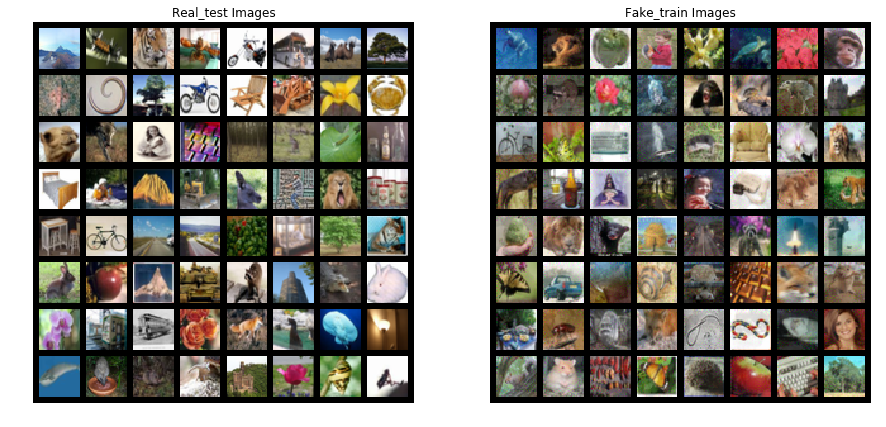

In [18]:
real_batch = next(iter(testloader))
fake_batch = next(iter(trainloader))
# print(real_batch.shape)
# print(real_batch[0].shape)
# print(img_list[2].shape)
a = torch.var(real_batch[0])
print(a)
b = torch.var(fake_batch[0])
print(b)
print(fake_batch[0].shape)
print(real_batch[0].shape)
c = torch.mean(real_batch[0])
d = torch.mean(fake_batch[0])
print(c)
print(d)
# 画出真实图像
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real_test Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))
# b = torch.var(img_list[-1],(1,2,0))
# print(b)
# 画出来自最后一次训练的假图像
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake_train Images")
plt.imshow(np.transpose(vutils.make_grid(fake_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))
# b = torch.var(img_list[-1],(1,2,0))
plt.show()

### Step 5: save model

In [7]:
## Method 1
torch.save(model.state_dict(), "MNIST-Classifier-purefake6train-epoch8-")

# the_model = TheModelClass(*args, **kwargs)
# model.load_state_dict(torch.load("LSTM-Model-nonbd-Epoch17-0330-1927"))

## Method 2
# torch.save(model, "MyBatchModel-Epoch2-GRU-0328-0953")
# the_model = torch.load(PATH)